<a href="https://colab.research.google.com/github/Bazinga97/Recommendation-system-/blob/main/Netflix_recommendation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd

# Path to the CSV file in Google Drive
path = "/content/drive/MyDrive/Colab Notebooks/netflix_titles.csv"

# Load the dataset into a Pandas dataframe called ratings and skip any lines that return an error
netflix_data = pd.read_csv(path)

In [3]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from plotly import graph_objects as go
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import os

In [7]:
print(netflix_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB
None


In [8]:
# Separate the dataset into TV shows and movies
tv_shows = netflix_data[netflix_data['type'] == 'TV Show'].copy()
movies = netflix_data[netflix_data['type'] == 'Movie'].copy()




<ipython-input-9-561a475efcc6>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='type', data=netflix_data, palette='Set2')


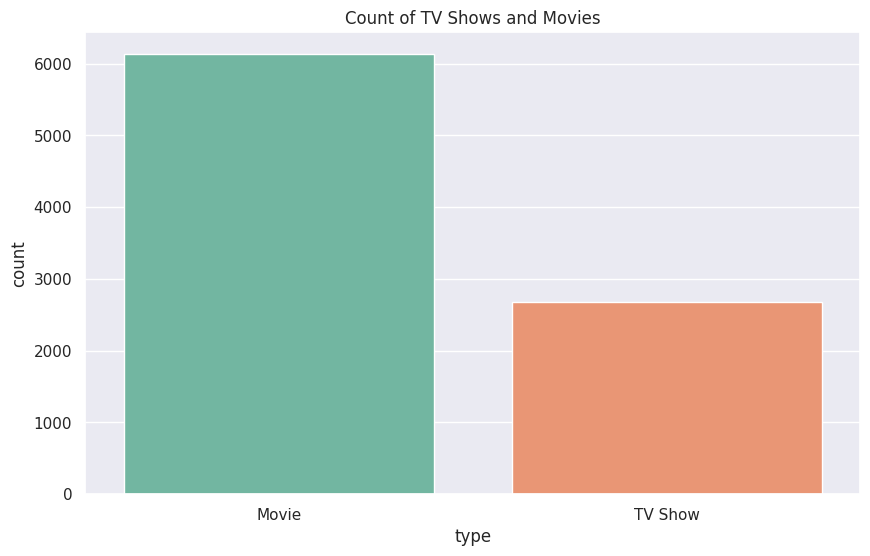

In [9]:
# Plot the count of TV shows and movies
sns.set(style='darkgrid')
plt.figure(figsize=(10, 6))
sns.countplot(x='type', data=netflix_data, palette='Set2')
plt.title('Count of TV Shows and Movies')
plt.show()

In [10]:
# Analyze the duration of content
duration_counts = pd.value_counts(netflix_data['duration'])
fig = go.Figure([go.Bar(x=duration_counts.index, y=duration_counts.values, text=duration_counts.values, marker_color='indianred')])
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(title_text='Duration of Content', xaxis_title='Duration', yaxis_title='Count')
fig.show()

In [11]:
# Handle missing values
missing_values = netflix_data.isna().sum()
print(missing_values)

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64


In [12]:
# Drop rows with missing 'date_added' values for TV shows
tv_shows = tv_shows.dropna(subset=['date_added'])

In [13]:

# Extract year and month from 'date_added'
tv_shows['year_added'] = tv_shows['date_added'].apply(lambda x: x.split(', ')[-1])
tv_shows['month_added'] = tv_shows['date_added'].apply(lambda x: x.split(' ')[0])

In [14]:
# Display the unique months
print(tv_shows['month_added'].unique())

['September' 'August' 'July' 'June' 'May' 'April' 'March' 'February'
 'January' 'December' 'November' 'October' '']


In [15]:

# Define the order of months
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']


In [16]:
# Group by year and month to count the number of TV shows added
monthly_additions = tv_shows.groupby('year_added')['month_added'].value_counts().unstack().fillna(0)[month_order].T
print(monthly_additions)

year_added   2008  2013  2014  2015  2016  2017  2018  2019  2020  2021
month_added                                                            
January       0.0   0.0   0.0   0.0  26.0  14.0  18.0  35.0  52.0  36.0
February      1.0   0.0   1.0   0.0   6.0  16.0  23.0  42.0  42.0  44.0
March         0.0   1.0   0.0   1.0   2.0  36.0  32.0  52.0  44.0  37.0
April         0.0   0.0   1.0   4.0   7.0  25.0  27.0  42.0  50.0  53.0
May           0.0   0.0   0.0   0.0   2.0  22.0  25.0  48.0  52.0  38.0
June          0.0   0.0   0.0   1.0   7.0  27.0  27.0  46.0  41.0  83.0
July          0.0   0.0   0.0   2.0   9.0  30.0  25.0  57.0  43.0  88.0
August        0.0   1.0   0.0   0.0  11.0  33.0  33.0  44.0  47.0  61.0
September     0.0   1.0   0.0   0.0  17.0  32.0  42.0  36.0  53.0  65.0
October       0.0   1.0   0.0   4.0  19.0  28.0  44.0  63.0  51.0   0.0
November      0.0   0.0   2.0   1.0  16.0  27.0  36.0  66.0  51.0   0.0
December      0.0   0.0   0.0   4.0  43.0  35.0  56.0  44.0  68.

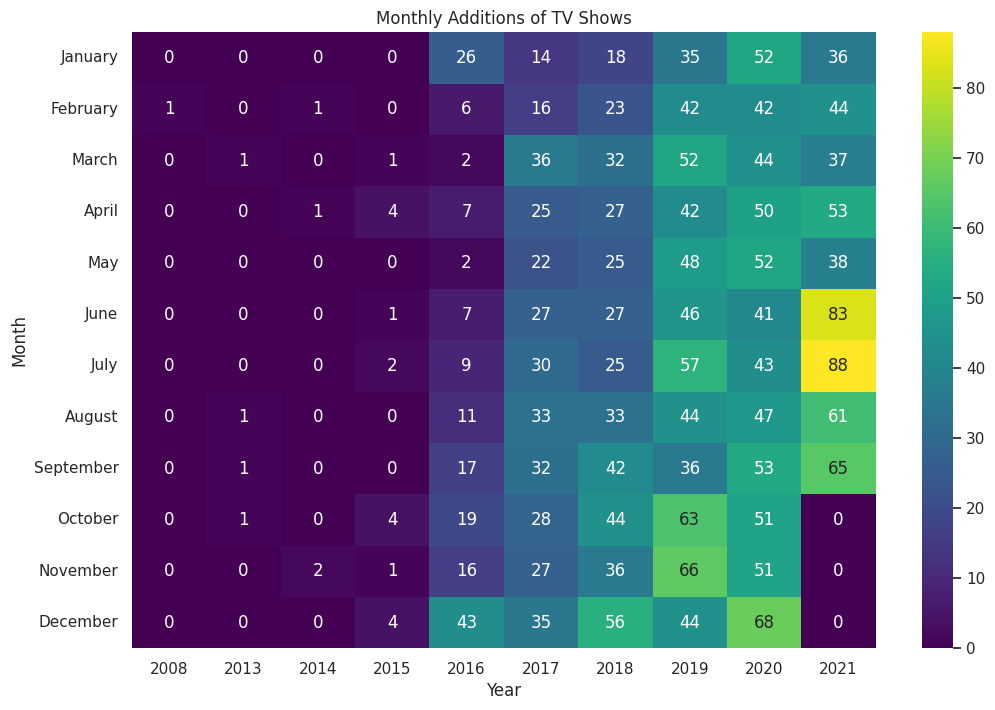

In [17]:
# Plot the monthly additions of TV shows
plt.figure(figsize=(12, 8))
sns.heatmap(monthly_additions, annot=True, fmt='g', cmap='viridis')
plt.title('Monthly Additions of TV Shows')
plt.xlabel('Year')
plt.ylabel('Month')
plt.show()


<ipython-input-18-633f6e179136>:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




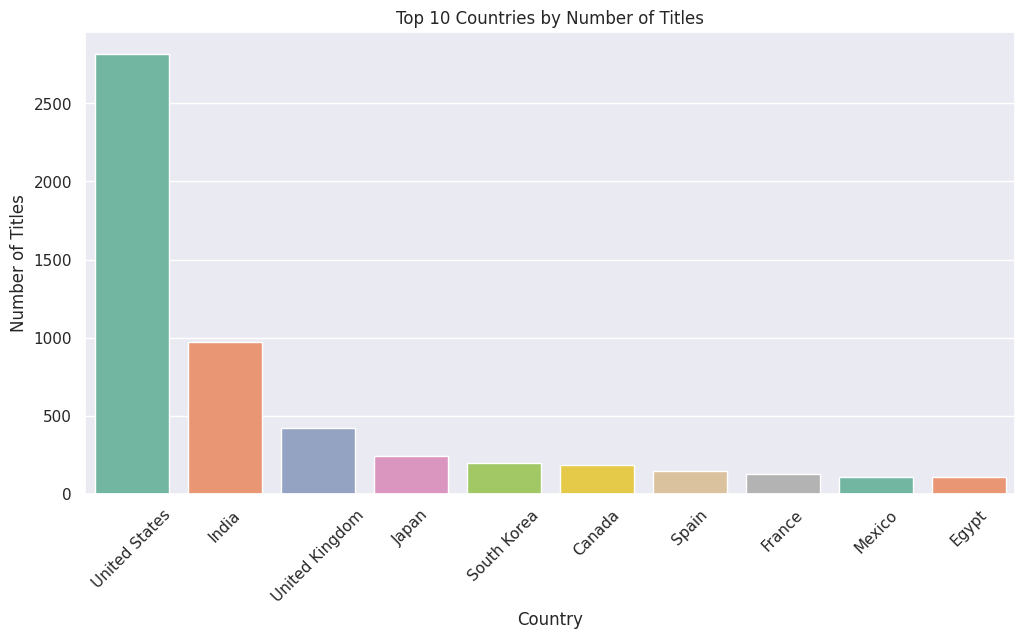

In [18]:
# Country-wise content analysis
country_counts = netflix_data['country'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=country_counts.index, y=country_counts.values, palette='Set2')
plt.title('Top 10 Countries by Number of Titles')
plt.xlabel('Country')
plt.ylabel('Number of Titles')
plt.xticks(rotation=45)
plt.show()

<ipython-input-19-2bf0a10db730>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




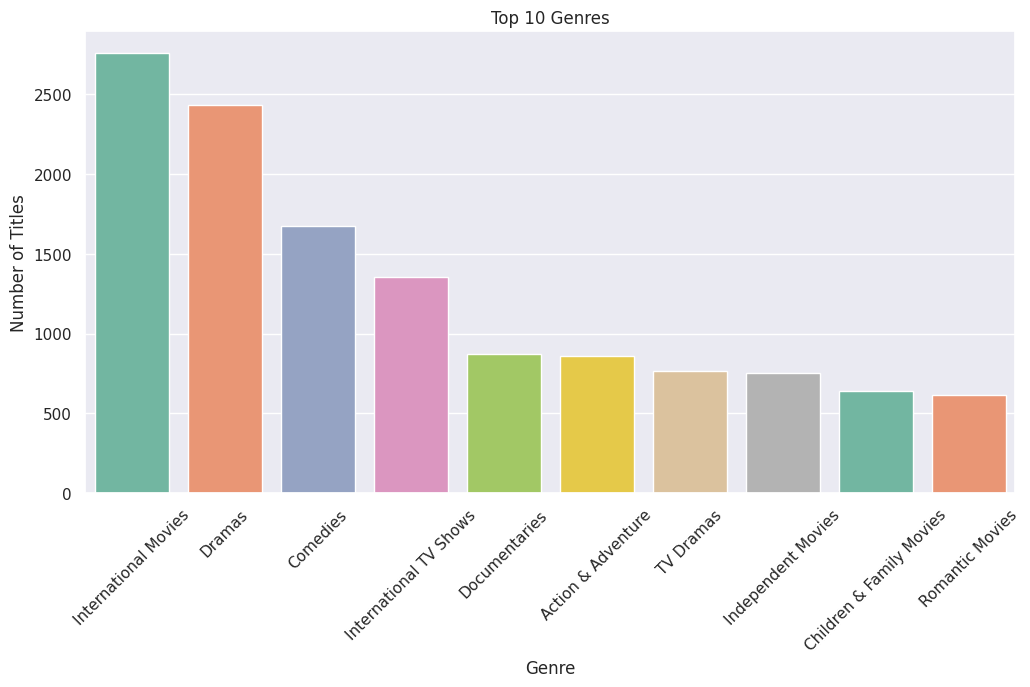

In [19]:
# Genre analysis
genres = netflix_data['listed_in'].str.split(', ').explode()
genre_counts = genres.value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='Set2')
plt.title('Top 10 Genres')
plt.xlabel('Genre')
plt.ylabel('Number of Titles')
plt.xticks(rotation=45)
plt.show()

<ipython-input-20-952f648a1010>:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




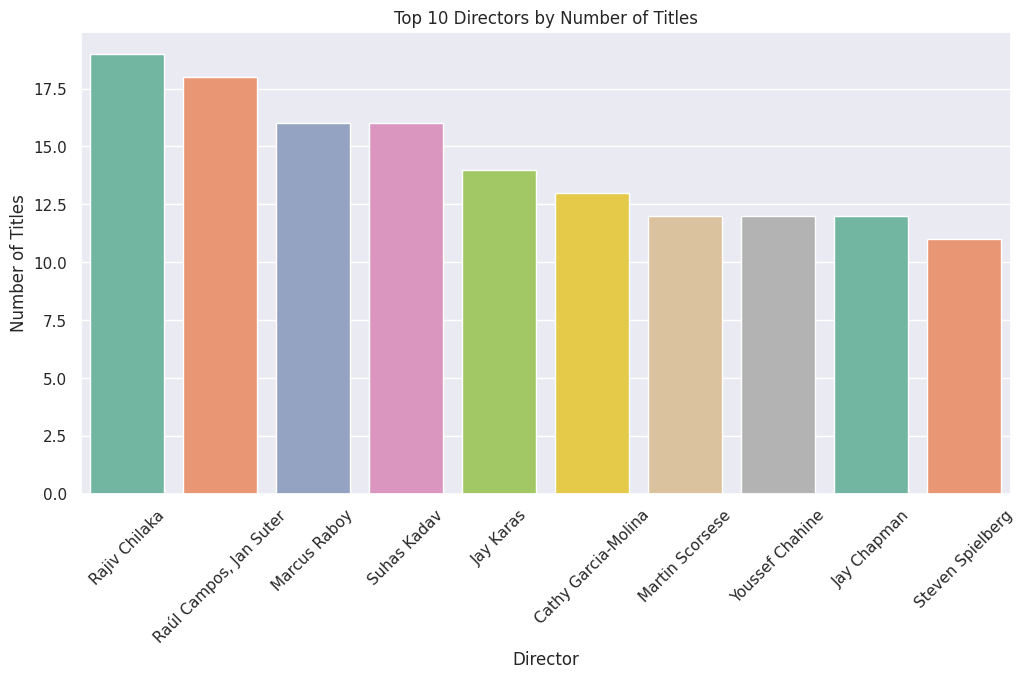

In [20]:
# Director influence analysis
director_counts = netflix_data['director'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=director_counts.index, y=director_counts.values, palette='Set2')
plt.title('Top 10 Directors by Number of Titles')
plt.xlabel('Director')
plt.ylabel('Number of Titles')
plt.xticks(rotation=45)
plt.show()

<ipython-input-21-358847333b2e>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




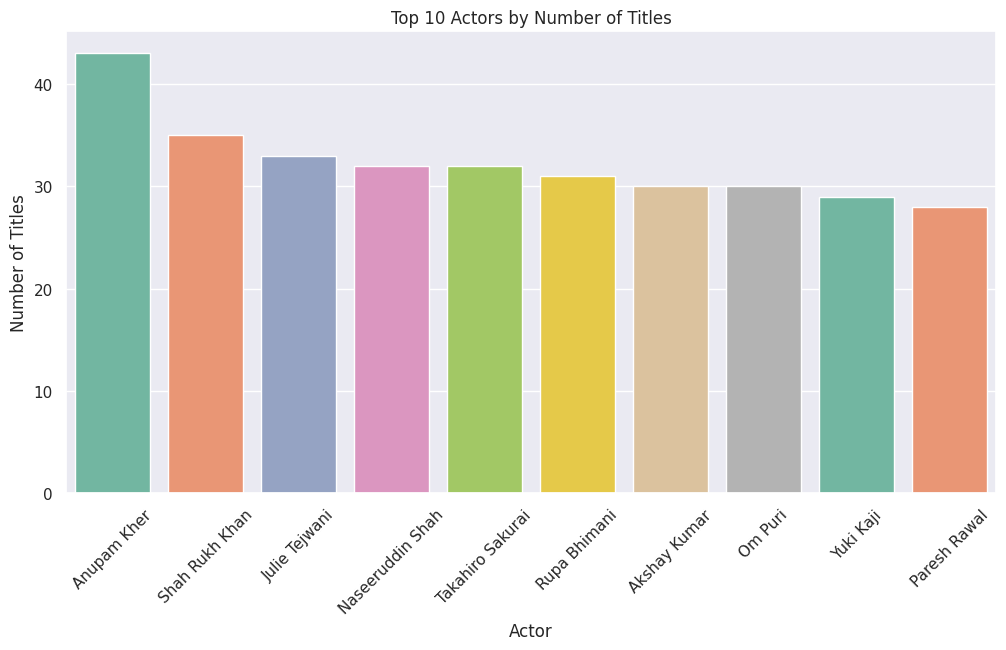

In [21]:

# Actor influence analysis
actors = netflix_data['cast'].str.split(', ').explode()
actor_counts = actors.value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=actor_counts.index, y=actor_counts.values, palette='Set2')
plt.title('Top 10 Actors by Number of Titles')
plt.xlabel('Actor')
plt.ylabel('Number of Titles')
plt.xticks(rotation=45)
plt.show()


<ipython-input-22-3962d7d9a3e5>:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




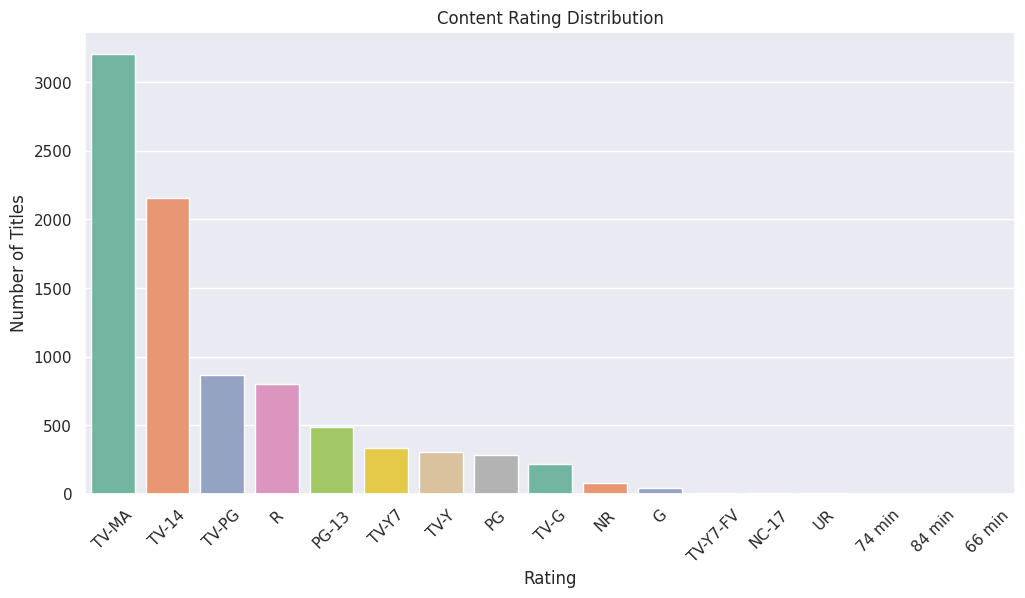

In [22]:
# Content rating distribution
rating_counts = netflix_data['rating'].value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(x=rating_counts.index, y=rating_counts.values, palette='Set2')
plt.title('Content Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Number of Titles')
plt.xticks(rotation=45)
plt.show()

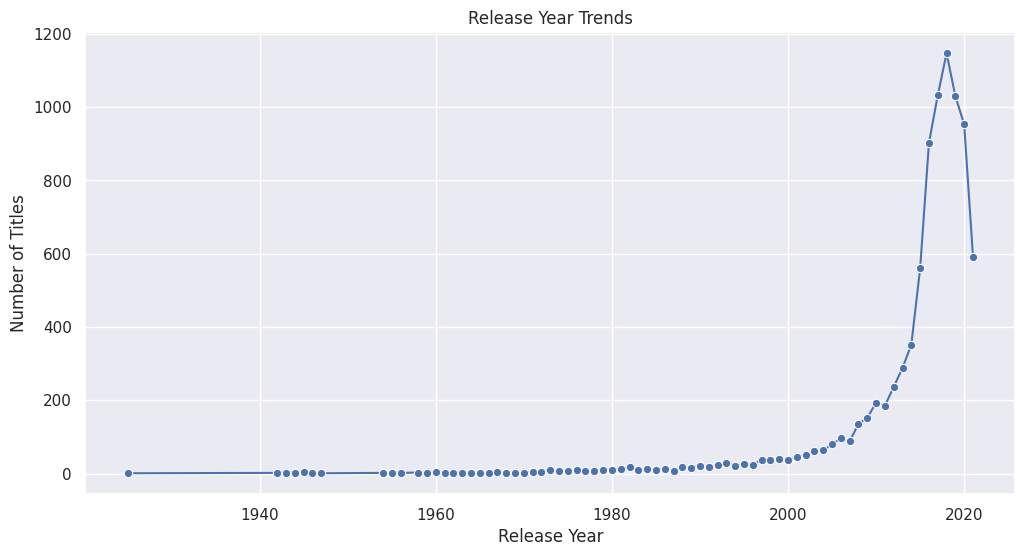

In [23]:

# Release year trends
release_year_counts = netflix_data['release_year'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
sns.lineplot(x=release_year_counts.index, y=release_year_counts.values, marker='o')
plt.title('Release Year Trends')
plt.xlabel('Release Year')
plt.ylabel('Number of Titles')
plt.show()

### Recommendation system

In [38]:
def recommend_shows(title, data, num_recommendations=5):
    # Check if the title exists in the dataset
    if title not in data['title'].values:
        return f"Title '{title}' not found in the dataset."

    print(f"Title '{title}' found in the dataset.")

    # Print the first few rows of the dataset to check the structure
    print(data.head())

    # Debug: Print the size of the dataset
    print("Dataset size:", data.shape)

    # Debug: Print the indices of shows where the title matches
    print("Indices of shows with matching title:")
    print(data[data['title'] == title].index)

    # Create a TF-IDF Vectorizer
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf_vectorizer.fit_transform(data['description'].fillna(''))

    # Compute cosine similarity
    cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

    # Get the index of the show that matches the title
    idx = data[data['title'] == title].index[0]

    # Get the pairwise similarity scores of all shows with that show
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the shows based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the most similar shows
    sim_scores = sim_scores[1:num_recommendations+1]

    # Get the show indices
    show_indices = [i[0] for i in sim_scores]

    # Return the top most similar shows
    return data['title'].iloc[show_indices]

# Example usage of the recommendation system
recommended_shows = recommend_shows('Stranger Things', tv_shows)
print(recommended_shows)


Title 'Stranger Things' found in the dataset.
  show_id     type                  title         director  \
1      s2  TV Show          Blood & Water              NaN   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans              NaN   
4      s5  TV Show           Kota Factory              NaN   
5      s6  TV Show          Midnight Mass    Mike Flanagan   

                                                cast       country  \
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...  South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...           NaN   
3                                                NaN           NaN   
4  Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...         India   
5  Kate Siegel, Zach Gilford, Hamish Linklater, H...           NaN   

           date_added  release_year rating   duration  \
1  September 24, 2021          2021  TV-MA  2 Seasons   
2  September 24, 2021          2021  TV-MA   1

IndexError: index 3685 is out of bounds for axis 0 with size 2666